# Transfer Learning

The learning goals of this tutorial are:

- Illustrate the transfer learning procedure using a model pre-trained on [ImageNet](http://www.image-net.org/).
- Get familiar with the Keras API to load pre-trained models and freeze layers during training.

## Step-by-step Procedure

1. Load dataset, explore it (display images, mean, min, max values, etc.) and split it into train, validation and test sets
2. Data scaling (use the same scaling technique as the one the pretrained model originally used)
    - [tf.keras.applications.resnet.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input)
3. One hot encoding
4. Define your callbacks (save your model, patience, etc.)
5. Set up data Augmentation

6. Transfer Learning
    
    6.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)
    
    6.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model
    
    6.3. Add a top (i.e., the prediction layers)
    
    6.4  Train the model using your dataset
    
    6.5 Unfreeze the layers and fine-tune the whole model (i.e., train your model with a very small learning rate)
    
    6.6 If you are satisfied with the train and validation performance go to the next step
    
    6.7 If you are not satisfied with the train and validation performance go back to step 6.1.

7. Test your model on the test and extract relevant metrics

In [ ]:
xtrain   ytrain
xval     yval
xtest    ytest
xtrain_mean = xtrain.mean()
xtrain_std = xtrain.std()
xtrain = (xtrain - xtrain_mean)/xtrain_std
xval = (xval - xtrain_mean)/xtrain_std
xtest = (xtest - xtrain_mean)/xtrain_std
xtrain = xtrain/255.0



"green", "black", "blue", "take-recycle"
 0,         1,      2,        3
    
 
[1, 0 , 0, 0]
[0, 1, 0,  0]
[0, 0, 1,  0]
[0, 0, 0,  1]





In [1]:
#! pip install scikit-image

In [2]:
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds # tensorflow datasets - pip install tensorflow-datasets
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import transform # pip install scikit-image

#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Load dataset, explore it  and split it into train, validation and test sets

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)

print(data_dir)
class_names = ["roses", "daisy",  "dandelion", "sunflowers", "tulips" ] 
images = np.asarray(glob.glob("C:\\Users\\rober\\.keras\datasets\\flower_photos\\*\\*.jpg"))
labels = np.asarray([f.split("\\")[-2] for f in images])

print(len(images))
print(images[:4])
print(labels[:4])

C:\Users\rober\.keras\datasets\flower_photos
3670
['C:\\Users\\rober\\.keras\\datasets\\flower_photos\\daisy\\100080576_f52e8ee070_n.jpg'
 'C:\\Users\\rober\\.keras\\datasets\\flower_photos\\daisy\\10140303196_b88d3d6cec.jpg'
 'C:\\Users\\rober\\.keras\\datasets\\flower_photos\\daisy\\10172379554_b296050f82_n.jpg'
 'C:\\Users\\rober\\.keras\\datasets\\flower_photos\\daisy\\10172567486_2748826a8b.jpg']
['daisy' 'daisy' 'daisy' 'daisy']


In [4]:
# Representing class names as integers 
Y = np.zeros(len(labels))
for ii in range(len(class_names)):
    Y[labels == class_names[ii]] =  ii

In [5]:
# Dimensions we will resize the images
img_height = 180
img_width = 180

X = np.zeros((len(images),img_height,img_width,3))
for (ii,img) in enumerate(images):
    X[ii] = transform.resize(plt.imread(img),(img_height,img_width,3))

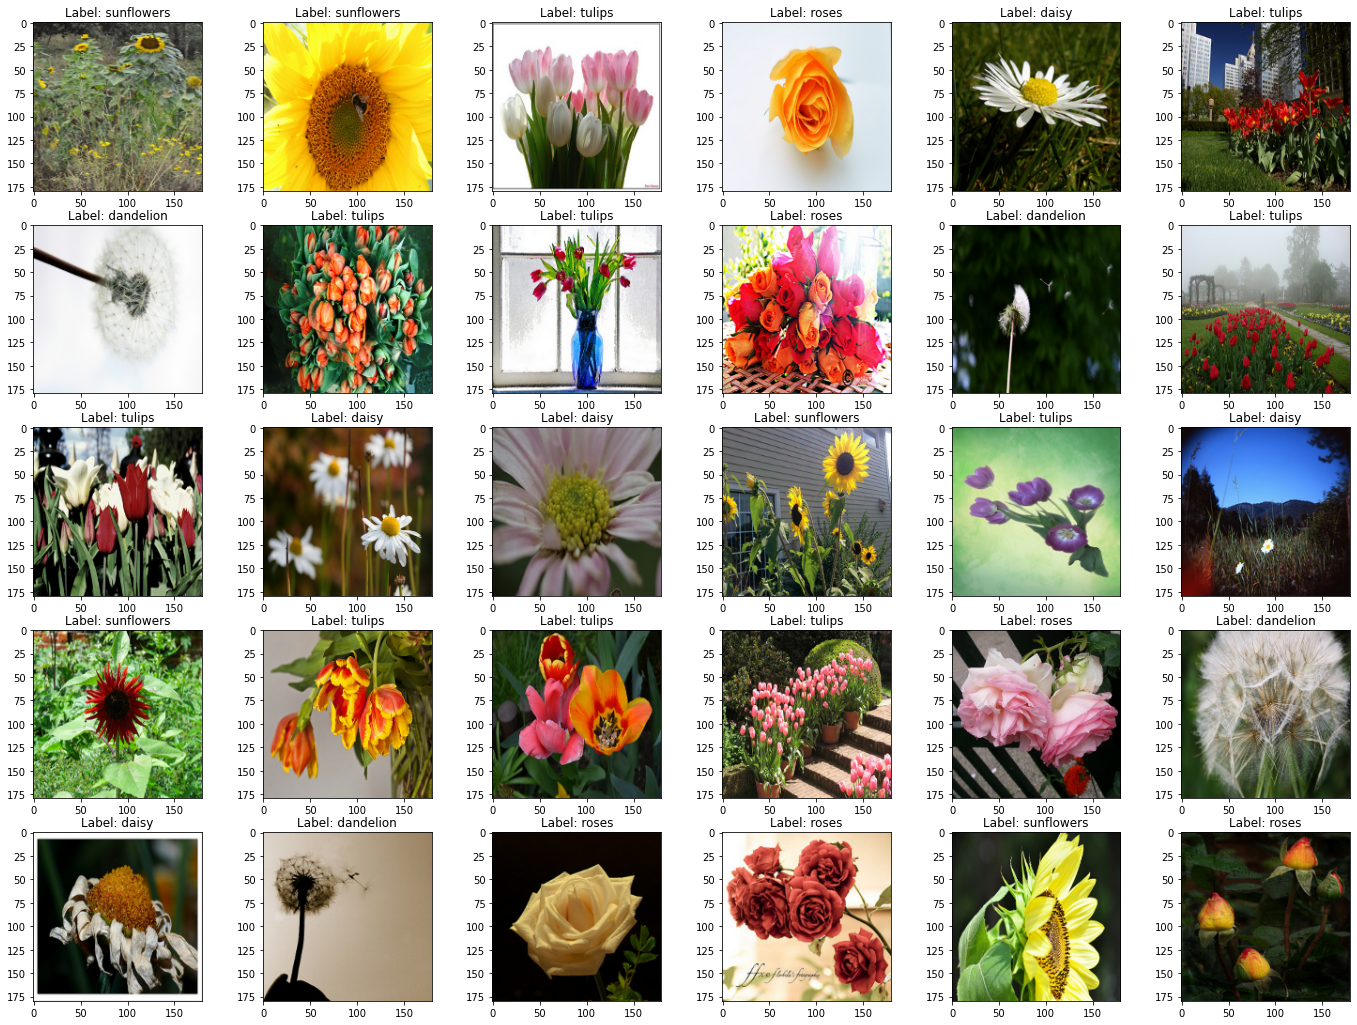

In [6]:
# Displaying some samples from the development set
sample_indexes = np.random.choice(np.arange(X.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X[jj], cmap = "gray")
    plt.title("Label: %s" %class_names[int(Y[jj])])
plt.show()

In [7]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X.shape[0], dtype = int)
np.random.shuffle(indexes)
X = X[indexes]*255
#X = tf.keras.applications.mobilenet.preprocess_input(X)
Y = Y[indexes]

# Train/validation/test split
nsplit1 = int(0.75*X.shape[0]) 
nsplit2 = int(0.9*X.shape[0]) 
# Train and validation split

X_train = X[:nsplit1]
Y_train = Y[:nsplit1]
X_val = X[nsplit1:nsplit2]
Y_val = Y[nsplit1:nsplit2]
X_test = X[nsplit2:]
Y_test = Y[nsplit2:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)


Train set
Images:  (2752, 180, 180, 3)
Labels shape:  (2752,)

Validation set
Images:  (551, 180, 180, 3)
Labels shape:  (551,)
Images:  (367, 180, 180, 3)
Labels shape:  (367,)


## 2. Data scaling

Use the same one as the originally pretrained model.

## 3. One hot encoding

In [8]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[3. 1. 2. 4. 0.]

One hot encoded labels:
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


## 4. Define your callbacks (save your model, patience, etc.)

In [9]:
model_name = "vgg_flowers_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 5. Keras Data Augmentation

In [10]:
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size) 

-0.27510485 0.61532044
-1.0 1.0


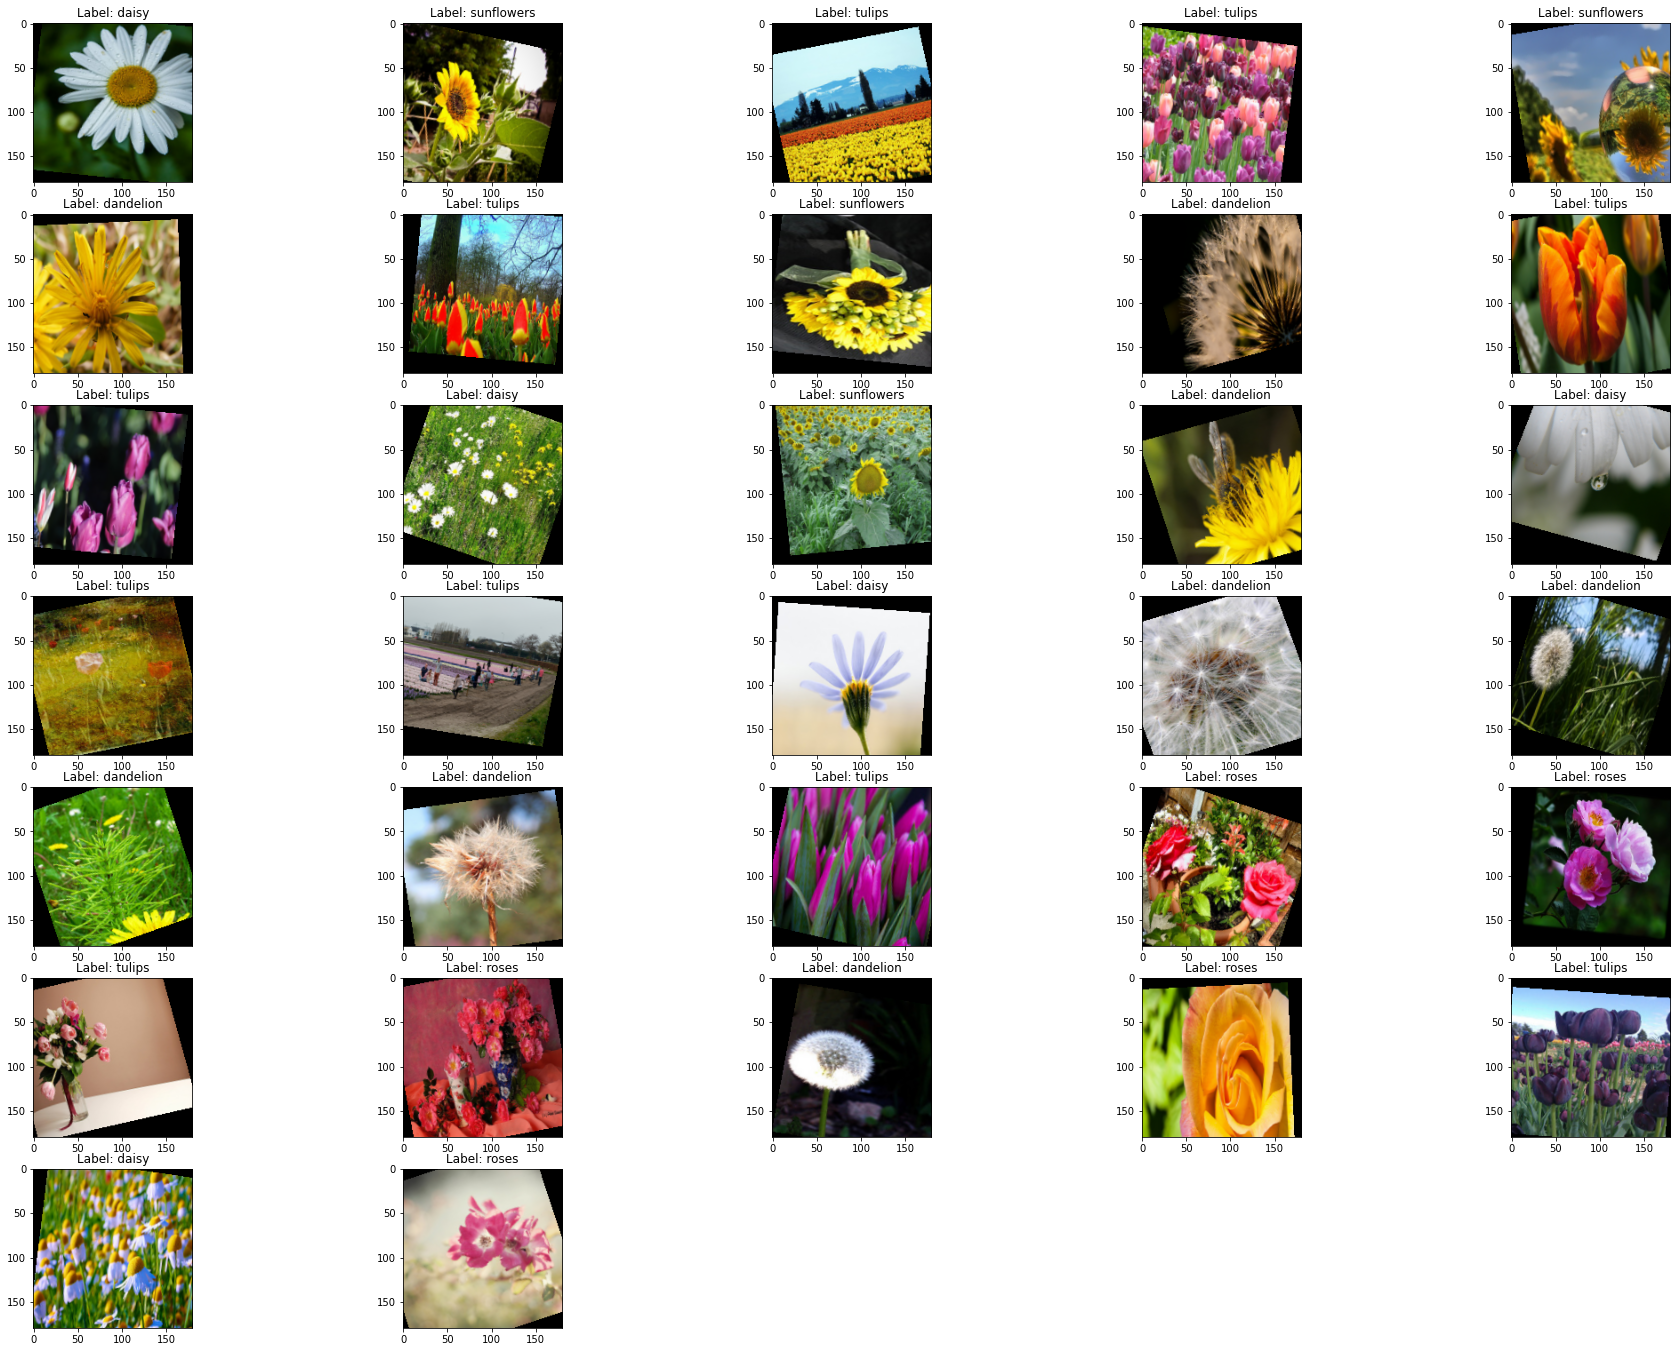

In [11]:
# Disaplying some samples from the development set
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %class_names[int(Ybatch[ii].argmax())])
plt.show()

## 6. Transfer Learning

6.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

6.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model

In [12]:
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

6.3. Add a top (i.e., the prediction layers)

In [13]:
#input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 163845    
Total params: 21,966,629
Trainable params: 163,845
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_flow,epochs = 2, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/2
86/86 [==============================] - 41s 312ms/step - loss: 1.3666 - accuracy: 0.5463 - val_loss: 0.7738 - val_accuracy: 0.7405
Epoch 2/2
86/86 [==============================] - 15s 176ms/step - loss: 0.5987 - accuracy: 0.7929 - val_loss: 0.6247 - val_accuracy: 0.7713


In [15]:
model = tf.keras.models.load_model(model_name)
model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())
model.fit(train_flow, epochs = 1, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 163845    
Total params: 21,966,629
Trainable params: 21,932,197
Non-trainable params: 34,432
_________________________________________________________________
None
86/86 [==============================] - 38s 197ms/step - loss: 0.4983 - accuracy: 0.8220 - val_loss: 0.5989 - val_accuracy: 0.7949


In [16]:
X_test = tf.keras.applications.mobilenet.preprocess_input(X_test)
model = tf.keras.models.load_model(model_name)
metrics = model.evaluate(X_test,Y_test_oh)

12/12 [==============================] - 11s 855ms/step - loss: 0.4888 - accuracy: 0.8256


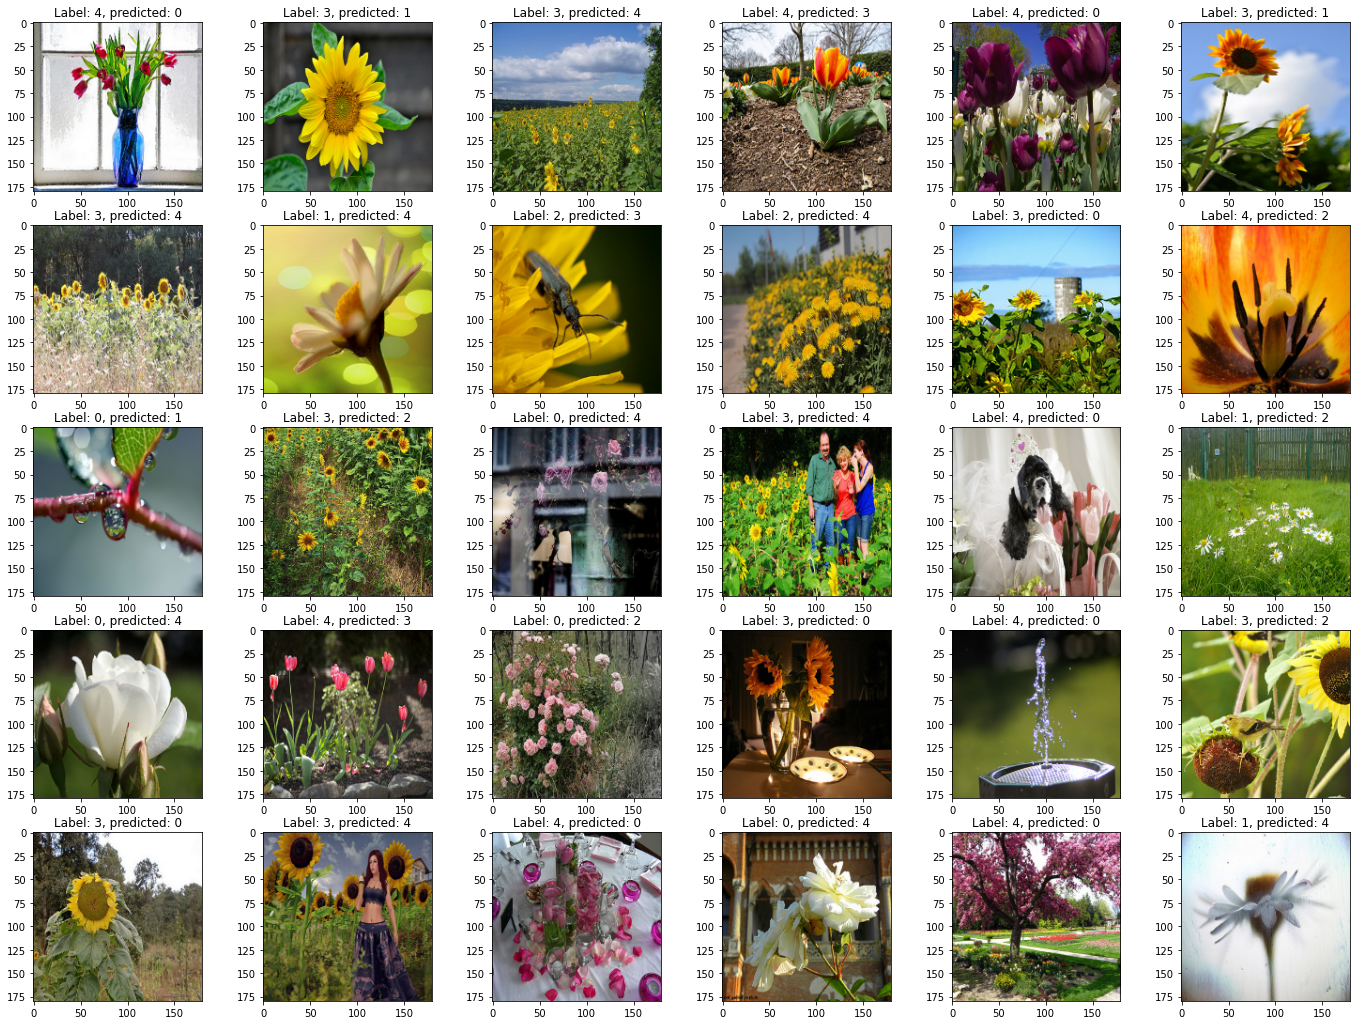

In [17]:
Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    aux = X_test[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()